- Two-Fluid Tearing Mode Numerical Solution 
- Finite Differences w/ Uniform Grid Spacing

In [392]:
using Plots # plots
using LaTeXStrings # plot labels
using LinearAlgebra # matrix math
using BenchmarkTools # calc runtime
using SparseArrays # efficient computation of matrices
using Arpack # need for eigs of sparse matrices

In [393]:
# Define functions for the current sheet f, f', f'' 
f(x) = tanh(x)
df(x) = sech(x)^2
ddf(x) = -2 * tanh(x) * sech(x)^2;

In [394]:
# Define constants
const S = 1000 #Lundquist number, # Int64
const η = 1/S 

γ = 0.01309 # Initial guess, # Float64

k = [-0.5, 0.5, 1.5] # m-1, m, m+1, # Vector{Float64}
# If k_{m} = 0.5, then I think khat = 0.5, m=1
# so k_{m±1} only differ from k_{m} by ±1

ux = 0 # radial flow, # Float64
uy = 0 # poloidal flow, # Float64

λ = [γ + im*k[i]*uy for i in eachindex(k)] # m-1 , m, m+1, # Vector{ComplexF64}

a, b = -10, 10
domain = (a, b)
n = 50

x = LinRange(a, b, n)
Δx = x[2] - x[1];

In [395]:
function discretizeSystem(λ, k, x, Δx)
    # Initialize the matrix A and the right-hand side vector b
    A = spzeros(ComplexF64, 6n, 6n)
    # b = spzeros(6n+1)

    # Fill-in coefficients of matrix A
    for i in 2:n-1
        # Function indices at the i'th grid point
        ɸ₋ = 6i - 5 # Index for ɸ m-1, i
        ψ₋ = 6i - 4 # Index for ψ m-1, i
        ɸ = 6i - 3  # Index for ɸ m, i
        ψ = 6i - 2  # Index for ψ m, i
        ɸ₊ = 6i - 1 # Index for ɸ m+1, i
        ψ₊ = 6i - 0 # Index for ψ m+1, i

        # Function indices at neighboring grid points
        # phi (need i±2 because of 3rd derivative)
        ɸ₋im1 = ɸ₋ - 6  # Index for ɸ m-1, i-1
        ɸ₋im2 = ɸ₋ - 12 # Index for ɸ m-1, i-2
        ɸ₋ip1 = ɸ₋ + 6  # Index for ɸ m-1, i+1
        ɸ₋ip2 = ɸ₋ + 12 # Index for ɸ m-1, i+2

        ɸim1 = ɸ - 6    # Index for ɸ m, i-1
        ɸim2 = ɸ - 12   # Index for ɸ m, i-2
        ɸip1 = ɸ + 6    # Index for ɸ m, i+1
        ɸip2 = ɸ + 12   # Index for ɸ m, i+2

        ɸ₊im1 = ɸ₊ - 6  # Index for ɸ m+1, i-1
        ɸ₊im2 = ɸ₊ - 12 # Index for ɸ m+1, i-2
        ɸ₊ip1 = ɸ₊ + 6  # Index for ɸ m+1, i+1
        ɸ₊ip2 = ɸ₊ + 12 # Index for ɸ m+1, i+2

        # psi (need i±1 only because no 3rd derivative)
        ψ₋im1 = ψ₋ - 6  # Index for ψ m-1, i-1
        ψ₋ip1 = ψ₋ + 6  # Index for ψ m-1, i+1

        ψim1 = ψ - 6    # Index for ψ m, i-1
        ψip1 = ψ + 6    # Index for ψ m, i+1

        ψ₊im1 = ψ₊ - 6  # Index for ψ m+1, i-1
        ψ₊ip1 = ψ₊ + 6  # Index for ψ m+1, i+1

        "Eqn 1 (ɸ m-1)"
        #i-2 points
        if i > 2
            A[ɸ₋, ɸim2] = -(ux*k[1])/(2*k[2]*(Δx^3))
        end

        # i-1 points
        if i > 1
            A[ɸ₋, ɸ₋im1] = λ[1] / Δx^2
            A[ɸ₋, ɸim1] = (k[1]/k[2]) * (ux/Δx^3)
            A[ɸ₋, ψ₋im1] = (k[1]^2*f(i)) / Δx^2
        end

        # i points
        A[ɸ₋, ɸ₋] = -λ[1] * ((2/Δx^2)+k[1]^2)
        A[ɸ₋, ψ₋] = -k[1]^2*(f(i)*(2/Δx^2) + f(i)*k[1]^2 - ddf(i))

        # i+1 points
        if i < n-1
            A[ɸ₋, ɸ₋ip1] = λ[1] / Δx^2
            A[ɸ₋, ɸip1] = -(k[1]/k[2]) * (ux/Δx^3)
            A[ɸ₋, ψ₋ip1] = (k[1]^2*f(i)) / Δx^2
        end

        # i+2 points
        if i < n-2
            A[ɸ₋, ɸip2] = (k[1]/k[2]) * (ux/(2*Δx^3))
        end
    
        "Eqn 2 (ψ m-1)"
        # i-1 points
        if i > 1
            A[ψ₋, ψim1] = -ux / (2*Δx)
            A[ψ₋, ψ₋im1] = -η / (Δx^2)
        end

        # i points
        A[ψ₋, ɸ₋] = -f(i)
        A[ψ₋, ψ₋] = λ[1] + (2*η)/(Δx^2) + η*k[1]^2

        # i+1 points
        if i < n-1
            A[ψ₋, ψip1] = ux / (2*Δx)
            A[ψ₋, ψ₋ip1] = -η / (Δx^2)
        end
        
        "Eqn 3 (ɸ m)"
        # i-2 points
        if i > 2
            A[ɸ, ɸ₊im2] = -(k[2]/k[3])*(ux/(2*Δx^3)) 
            A[ɸ, ɸ₋im2] = -(k[2]/k[1])*(ux/(2*Δx^3))
        end

        # i-1 points
        if i > 1
            A[ɸ, ɸ₊im1] = (k[2]/k[3])*(ux/(Δx^3))
            A[ɸ, ɸ₋im1] = (k[2]/k[1])*(ux/(Δx^3))
            A[ɸ, ɸim1] = λ[2]/Δx^2
            A[ɸ, ψim1] = k[2]^2*f(i) / Δx^2
        end

        # i points
        A[ɸ, ɸ] = -λ[2]*( (2/Δx^2) + k[2]^2)
        A[ɸ, ψ] = ((-2*k[2]^2*f(i))/Δx^2 - k[2]^4*f(i) + k[2]^2*ddf(i))

        # i+1 points
        if i < n-1
            A[ɸ, ɸ₊ip1] = -(k[2]/k[3])*(ux/(Δx^3))
            A[ɸ, ɸ₋ip1] = -(k[2]/k[1])*(ux/(Δx^3))
            A[ɸ, ɸip1] = λ[2]/Δx^2
            A[ɸ, ψip1] = k[2]^2*f(i) / Δx^2
        end

        # i+2 points
        if i < n-2
            A[ɸ, ɸ₊ip2] = (k[2]/k[3])*(ux/(2*Δx^3))
            A[ɸ, ɸ₋ip2] = (k[2]/k[1])*(ux/(2*Δx^3))
        end

        "Eqn 4 (ψ m)"
        # i-1 points
        if i > 1
            A[ψ, ψ₋im1] = -ux / (2*Δx)
            A[ψ, ψ₊im1] = -ux / (2*Δx)
            A[ψ, ψim1] = -η / (Δx^2)
        end
        
        # i points
        A[ψ, ψ] = λ[2] + (2*η/Δx^2) + η*k[2]^2
        A[ψ, ɸ] = -f(i)

        # i+1 points
        if i < n-1
            A[ψ, ψ₋ip1] = ux / (2*Δx)
            A[ψ, ψ₊ip1] = ux / (2*Δx)
            A[ψ, ψip1] = -η/ (Δx^2)
        end

        "Eqn 5 (ɸ m+1)"
        # i-2 points
        if i > 2
            A[ɸ₊, ɸim2] = -(k[3]/k[2])*(ux/(2*Δx^3))
        end

        # i-1 points
        if i > 1
            A[ɸ₊, ɸim1] = (k[3]/k[2])*(ux/(Δx^3))
            A[ɸ₊, ɸ₊im1] = λ[3]/Δx^2
            A[ɸ₊, ψ₊im1] = k[3]^2*f(i) / Δx^2
        end

        # i points
        A[ɸ₊, ɸ₊] = -λ[3]*((2/Δx^2) + k[3]^2)
        A[ɸ₊, ψ₊] = -(2*k[3]^2*f(i))/(Δx^2) - k[3]^4*f(i) + k[3]^2*ddf(i)

        # i+1 points
        if i < n-1
            A[ɸ₊, ɸip1] = -(k[3]/k[2])*(ux/(Δx^3))
            A[ɸ₊, ɸ₊ip1] = λ[3]/Δx^2
            A[ɸ₊, ψ₊ip1] = k[3]^2*f(i) / Δx^2
        end

        # i+2 points
        if i < n-2
            A[ɸ₊, ɸip2] = (k[3]/k[2])*(ux/(2*Δx^3))
        end

        "Eqn 6 (ψ m+1)"
        # i-1 points
        if i > 1
            A[ψ₊, ψim1] = -ux / (2*Δx)
            A[ψ₊, ψ₊im1] = -η / (Δx^2)
        end

        # i points
        A[ψ₊, ɸ₊] = -f(i)
        A[ψ₊, ψ₊] = λ[3] + (2*η)/(Δx^2) + η*k[3]^2

        # i+1 points
        if i < n-1
            A[ψ₊, ψip1] = ux / (2*Δx)
            A[ψ₊, ψ₊ip1] = -η / (Δx^2)
        end
        
    end

    # Set first and last rows to zero
    A[1:6, :] .= 0
    A[end-5:end, :] .= 0

    # Now set the first 6 diagonal elements to 1
    for i in 1:6
        A[i, i] = 1
    end

    # And set the last 6 diagonal elements to 1
    for i in 6n-5:6n
        A[i, i] = 1
    end
    
    return A
end

discretizeSystem (generic function with 1 method)

In [396]:
A = discretizeSystem(λ, k, x, Δx)

300×300 SparseMatrixCSC{ComplexF64, Int64} with 1819 stored entries:
⎡⢵⣤⣤⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠈⠝⣿⣷⣆⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠐⢹⢿⣿⣥⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠉⠝⣿⣷⣆⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠐⠹⢿⣿⣵⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠉⠟⣿⣷⣆⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠹⢿⣿⣴⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢟⣿⣷⣆⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠹⢿⣿⣔⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢟⣿⣷⣇⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠹⢿⣿⣔⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢛⣿⣷⣇⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠹⢿⣿⣔⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢛⢿⣷⣥⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠽⢿⣿⣔⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢛⢿⣷⣥⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠽⣿⣿⣔⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⢛⢿⣷⣥⢀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠝⣿⣿⣖⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⠛⠛⢄⎦

In [397]:
A[1:6, 1:6]

6×6 SparseMatrixCSC{ComplexF64, Int64} with 6 stored entries:
 1.0+0.0im      ⋅          ⋅          ⋅          ⋅          ⋅    
     ⋅      1.0+0.0im      ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅      1.0+0.0im      ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅      1.0+0.0im      ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅      1.0+0.0im      ⋅    
     ⋅          ⋅          ⋅          ⋅          ⋅      1.0+0.0im

In [398]:
A[end-5:end, end-5:end]

6×6 SparseMatrixCSC{ComplexF64, Int64} with 6 stored entries:
 1.0+0.0im      ⋅          ⋅          ⋅          ⋅          ⋅    
     ⋅      1.0+0.0im      ⋅          ⋅          ⋅          ⋅    
     ⋅          ⋅      1.0+0.0im      ⋅          ⋅          ⋅    
     ⋅          ⋅          ⋅      1.0+0.0im      ⋅          ⋅    
     ⋅          ⋅          ⋅          ⋅      1.0+0.0im      ⋅    
     ⋅          ⋅          ⋅          ⋅          ⋅      1.0+0.0im

In [399]:
# Shift μ (commonly set to zero for finding the smallest eigenvalue)
μ = 0.0 - 0.0im
I = spdiagm(0 => ones(ComplexF64, 6n))

# Initial guess for the eigenvector
v = rand(ComplexF64, 6n)
v /= norm(v)

# Parameters for iteration
tol = 1e-8
max_iter = 1000

# Inverse iteration loop
for k in 1:max_iter
    # Solve (A - μI) * v_new = v
    v_new = (A - μ * I) \ v

    # Normalize the new vector
    v_new /= norm(v_new)

    # Check for convergence
    if norm(v_new - v) < tol
        println("Converged in $k iterations.")
        break
    end

    v = v_new
end

# Estimate the eigenvalue using the Rayleigh quotient
σ = (v' * A * v) / (v' * v)
println("Estimated smallest eigenvalue: $σ")
# println("Associated eigenvector: $v");

# Estimated smallest eigenvalue: -0.0033802916256113766 - 1.2705528929924674im 
# took 13.2 s (compared to 1m 38s using nonsparse matrix, find ALL eigenvals + eigenvecs)

Estimated smallest eigenvalue: -0.25731208068093747 - 1.5543122344752192e-15im


In [400]:
phimm1 = real.(v[1:6:end])
phim = real.(v[2:6:end])
phimp1 = real.(v[3:6:end])
psimm1 = real.(v[4:6:end])
psim = real.(v[5:6:end])
psimp1 = real.(v[6:6:end]);

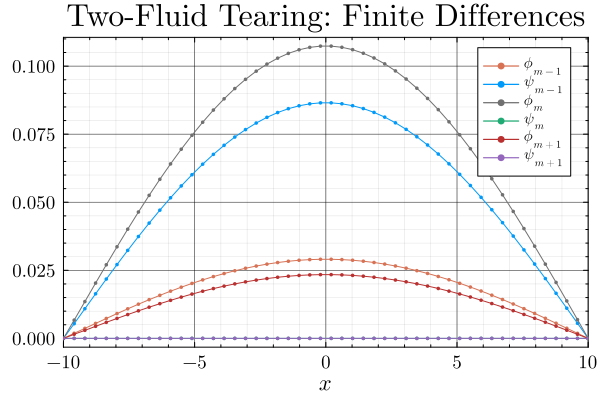

In [401]:
theme(:dao::Symbol)

myplot = plot(x, [phimm1 psimm1 phim psim phimp1 psimp1],
    markershape=:circle,
    markersize=2,
    lw=1,
    xlims=(a,b),
    # xlims=(-1//2, 1//2),
    legend=:best,
    labels=[L"$\phi_{m-1}$" L"$\psi_{m-1}$" L"$\phi_{m}$" L"$\psi_{m}$" L"$\phi_{m+1}$" L"$\psi_{m+1}$"],
    title="Two-Fluid Tearing: Finite Differences",
    xlabel=L"$x$",
    # ylabel=L"$\psi_{m}(x), \phi_{m}(x)$",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=10, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
)
# savefig(myplot, "tf_tearing_finitediff_wrong.png")
myplot

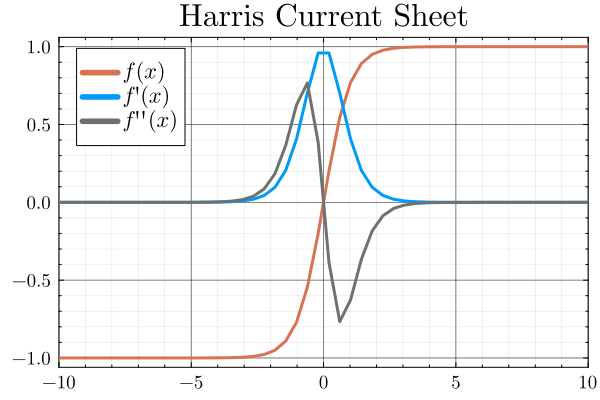

In [402]:
theme(:dao)
plot(x, [f.(x) df.(x) ddf.(x)],
    lw=3, 
    xlims=(-10,10),
    legend=:best,
    labels=[L"$f(x)$" L"$f'(x)$" L"$f''(x)$"],
    title="Harris Current Sheet",
    titlefontsize=20,  # title
    tickfontsize=12,  # ticks
    legendfontsize=15, # legend
    yguidefontsize=15, # guides
    xguidefontsize=15
    )

In [403]:
#= Plot the spectrum of eigenvalues
vals, vecs = eigs(A, nev=500, which=:LR)
scatter(real.(vals), imag.(vals), 
    markersize=2,
    xlabel="Real Part",
    ylabel="Imaginary Part",
    title="Eigenvalue Spectrum",
    legend=false)
=#

In [404]:
# Open a file to write
#=
open("sparse_matrix.txt", "w") do file
    row_indices, col_indices, values = findnz(A)
    for (i, j, value) in zip(row_indices, col_indices, values)
        println(file, "$i $j $value")
    end
end
=#